<a href="https://colab.research.google.com/github/Santosw-Git/GANs_In_Mnist/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import torch
import torchvision
from torchvision.transforms import ToTensor , Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root="data",
              train=True,
              download=True,
              transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])
)

In [74]:
img , label=mnist[0]
torch.min(img), torch.max(img)
len(mnist)


60000

In [75]:

img.shape
img.squeeze().shape


torch.Size([28, 28])

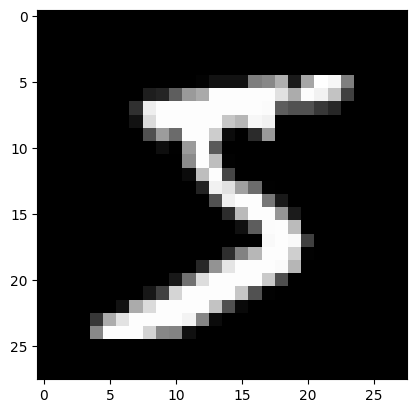

In [76]:
import matplotlib.pyplot as plt
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [77]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [78]:
torch.min(denorm(img))

tensor(0.)

In [101]:
from torch.utils.data import DataLoader
batch_size = 100
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)
len(data_loader)

600

In [80]:
for images, labels in data_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100])


In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
device

device(type='cuda')

# Discriminator Network

In [83]:
input_size=28*28
hidden_layer=256

In [84]:
import torch.nn as nn
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_D=nn.Sequential(
            nn.Linear(input_size, hidden_layer),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_layer, hidden_layer),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_layer, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model_D(x)



In [85]:
model_discriminator=Discriminator()
model_discriminator=model_discriminator.to(device)

In [86]:
model_discriminator

Discriminator(
  (model_D): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

# Generator Network

In [87]:

latent_size = 64

class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.model_G = nn.Sequential(
            nn.Linear(latent_size, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, input_size),
            nn.Tanh()
        )



    def forward(self, x):
        return self.model_G(x)



In [88]:
generator = Generator(latent_size)
generator = generator.to(device)

z = torch.randn(2, latent_size).to(device)
y = generator(z)
print(y.shape)


torch.Size([2, 784])


In [89]:
gen_images=denorm(y.reshape(-1,28,28))

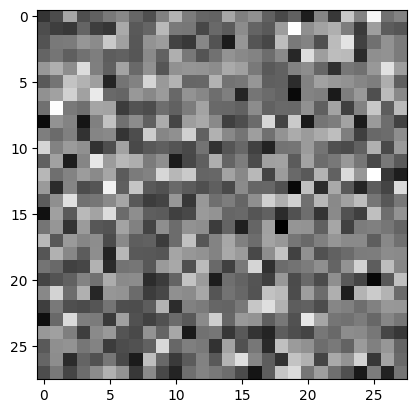

In [90]:

# Move the tensor to CPU, detach, and plot
plt.imshow(gen_images[0].cpu().detach(), cmap="gray")
plt.show()


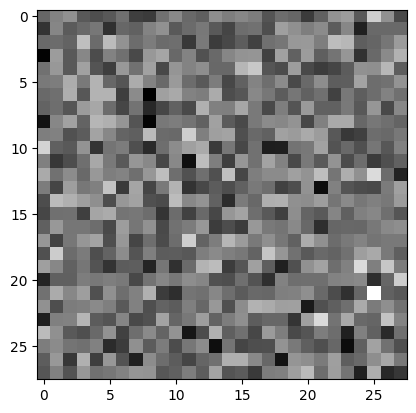

In [91]:
plt.imshow(gen_images[1].cpu().detach().numpy(), cmap="gray")
plt.show()

# Discriminator Training

In [92]:
d_optimizer=torch.optim.Adam(model_discriminator.parameters(), lr=0.0002)
g_optimizer=torch.optim.Adam(generator.parameters(), lr=0.0002)
loss_function=nn.BCELoss()

In [100]:
def reset_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()


def train_discriminator(images):
  real_labels=torch.ones(batch_size, 1).to(device)
  fake_labels=torch.zeros(batch_size, 1).to(device)

  real_out=model_discriminator(images)
  real_loss=loss_function(real_out, real_labels)
  real_score=real_out

  z=torch.randn(batch_size, latent_size).to(device)
  fake_images=generator(z)
  fake_out=model_discriminator(fake_images)
  fake_loss=loss_function(fake_out, fake_labels)
  fake_score=fake_out

  loss=real_loss+fake_loss
  reset_grad()

  loss.backward()

  d_optimizer.step()
  return loss , real_loss, fake_loss

In [110]:
def train_generator():

  z=torch.randn(batch_size, latent_size).to(device)
  fake_images=generator(z)
  labels=torch.ones(batch_size, 1).to(device)
  g_loss=loss_function(model_discriminator(fake_images), labels)


  reset_grad()
  g_loss.backward()
  g_optimizer.step()

  return g_loss,fake_images

## Lets create a dir where we can save intermediate outputs from the generator to visually inspect the progress of the model.



In [95]:
import os
sample_dir= 'samples'
if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

Lets save a batch of real images that we can use for visual comparision while looking at the generated images.

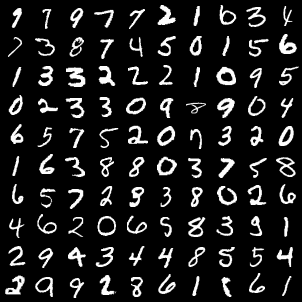

In [96]:
from IPython.display import Image
from torchvision.utils import save_image

#Save some real images
for images, _ in data_loader:
  # images = images.to(device)
  images = images.reshape(images.size(0),1,28,28)
  save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
  # break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


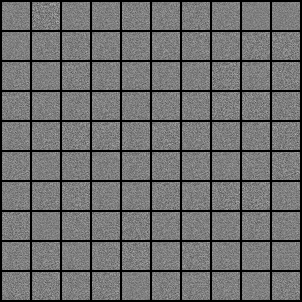

In [97]:
sample_vector = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
  fake_images = generator(sample_vector)
  fake_images = fake_images.reshape(fake_images.size(0),1,28,28)
  fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
  print('Saving', fake_fname)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname),nrow=10)

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses = []
g_losses = []
real_scores = []
fake_scores = []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Train discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        if (i+1)%200==0:
          d_losses.append(d_loss.item())
          g_losses.append(g_loss.item())
          real_scores.append(real_score.mean().item())
          fake_scores.append(fake_score.mean().item())
          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}',
                epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item())


    # Save fake images generated at the end of each epoch
    save_fake_images(epoch + 1)


Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f} 0 300 200 600 0.9093632698059082 1.6790320873260498 0.5052940249443054 0.4040692150592804
Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f} 0 300 400 600 0.7367448806762695 2.477248191833496 0.5739177465438843 0.16282710433006287
Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f} 0 300 600 600 0.6967124938964844 2.0404841899871826 0.4281110167503357 0.2686014771461487
Saving fake_images-0001.png
Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f} 1 300 200 600 0.8886107206344604 2.1700544357299805 0.5454151630401611 0.34319552779197693
Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f} 1 300 400 600 0.8042526841163635 1.4324456453323364 0.4799381196498871 0.32431456446647644
Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x)